# Drop Profile Analysis Using Polar Coordinates

This notebook analyzes sessile drop profiles by implementing a more general approach using polar coordinate interpolation for droplet edges and Young-Laplace equation fitting.

## Key Features:
- **Edge Detection**: Uses Canny edge detection to identify drop boundaries
- **Coordinate Transformation**: Converts from image pixels to physical coordinates (mm)
- **Profile Fitting**: Employs spline interpolation for smooth edge representation
- **Contact Angle Measurement**: Calculates left and right contact angles from tangent slopes
- **Young-Laplace Fitting**: Fits theoretical drop shape to extract surface tension
- **Pressure Analysis**: Computes pressure difference across the interface using fitted parameters

## Physical Parameters Extracted:
- Surface tension (γ)
- Contact angles (θ_left, θ_right)
- Drop dimensions (base radius, height)
- Radius of curvature at apex
- Laplace pressure difference (ΔP)

This approach provides a robust framework for analyzing droplet wetting behavior and interfacial properties.

### About the Author — Sarah Yao

Sarah Yao, Ames High School student, from Ames, Iowa, developed this code during her internship with NSF’s ChemMatCARS under Dr. Mrinal Bera, Dr. Jiajun Tian and Dr. Wei Bu. In the process, she explored pendant drop tensiometry for analyzing liquid surfaces and used data fitting methods to extract parameters valuable to scientific research. She values the opportunity to contribute to the project and learn from the team.

#### Image Loading and Display

Loads a TIFF image in grayscale, prints its dimensions, and displays it using matplotlib for visual inspection. This step ensures the image is correctly loaded and helps identify the region of interest for further analysis.

In [25]:
# check and add missing python packages
import subprocess
import sys

required_packages = [
    "numpy",
    "scipy",
    "matplotlib",
    "opencv-python"
]

# check and install missing packages
for package in required_packages:
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

Image shape: (480, 640)


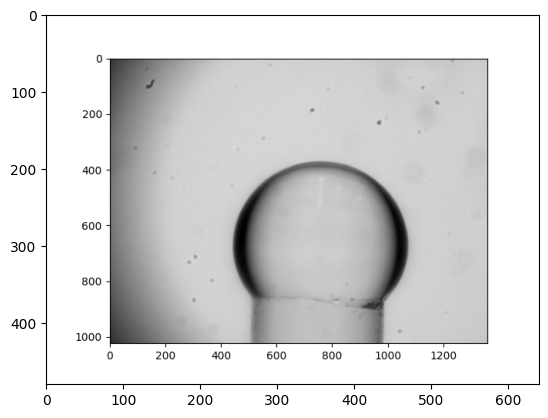

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image from file using OpenCV in grayscale mode
# This will read the image as a single channel (grayscale)
# The image is expected to be in TIFF format, which can have multiple channels.
image_orig = cv2.imread('data/drop_figure4.tiff', cv2.IMREAD_GRAYSCALE)

# Read TIFF file with OpenCV; TIFFs can have multiple channels, e.g., BGRA (4 channels)
# The final dimension of 4 indicates the image has 4 channels (Blue, Green, Red, Alpha)
print(f"Image shape: {image_orig.shape}")
# Crop the image to focus on the region of interest
# Truncate the final dimension to keep only the first 3 channels (BGR).
# This is necessary because OpenCV's cvtColor expects a 3-channel image for conversion to grayscale.
# If the image has an alpha channel (4th channel), it should be removed before grayscale conversion.
# Display the original image using matplotlib
plt.figure()
plt.imshow(image_orig, cmap='gray')
plt.show()

#### Cropping the Image

This code crops the loaded grayscale image to focus on the region containing the droplet, then displays the cropped area using matplotlib. Cropping helps isolate the drop from the background and prepares the image for subsequent edge detection and analysis.

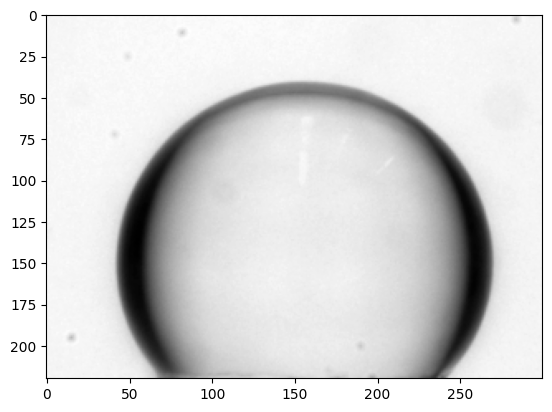

In [27]:
image = image_orig[150:370, 200:500]  # Adjust the crop dimensions as needed
# Display the cropped image
plt.figure()
plt.imshow(image, cmap='gray')
plt.show()

#### Edge Detection with Canny Algorithm

This code applies the Canny edge detection algorithm to the cropped grayscale image to identify the boundaries of the droplet. Thresholds for edge detection are set based on the image intensity range, and the resulting edge map is displayed for visual verification.

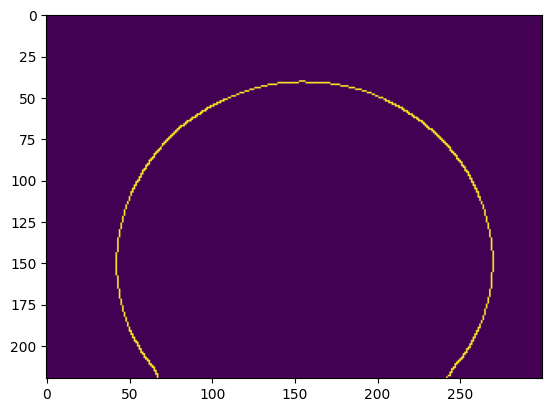

In [28]:
# Set thresholds for Canny edge detection based on image intensity
thres1 = image.min() * 0.75
thres2 = image.max() * 1.4

# Apply Canny edge detection
edges = cv2.Canny(image, thres1, thres2)
# Display the detected edges
plt.figure()
plt.imshow(edges)
plt.show()


#### Extracting and Plotting Edge Coordinates
This code locates the coordinates of edge pixels from the Canny edge-detected image, converts them to float, and inverts the y-axis for correct orientation in plotting. The detected edge points are then visualized as a scatter plot to verify the accuracy of edge detection.

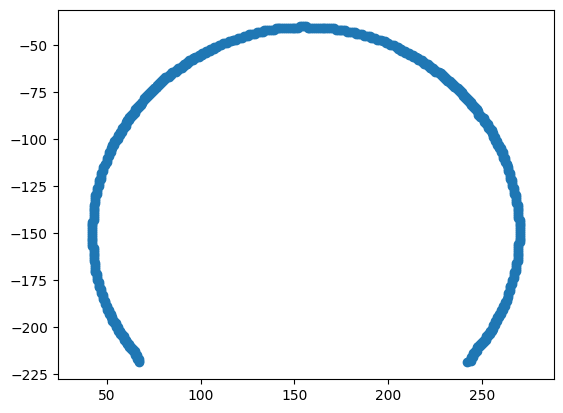

In [29]:
# Find the coordinates of edge pixels from the edge image
ys, xs = np.where(edges > 0)  # ys: row indices, xs: column indices where edge is detected

# Convert coordinates to float and invert ys for plotting (origin at bottom)
# The negation is necessary because in image processing, the origin (0,0) is at the top-left corner,
# while in most plotting libraries, the origin is at the bottom-left corner.
# In image arrays, the origin (0,0) is at the top-left, so increasing y moves downward.
# By negating ys, increasing y moves upward in the plot.
ys = np.asarray(-ys, dtype=float)
xs = np.asarray(xs, dtype=float)

# Display the edge points as a scatter plot
plt.figure()
plt.plot(xs, ys, marker='o', ls='none')
plt.axis('equal')
plt.show()

#### Centering and Shifting Edge Coordinates
This section centers the x-coordinates of the detected edge points by subtracting their mean and shifts the y-coordinates so that the minimum value is zero, aligning the drop base with the horizontal axis. The adjusted edge points are then plotted to visualize the centered and shifted droplet profile.

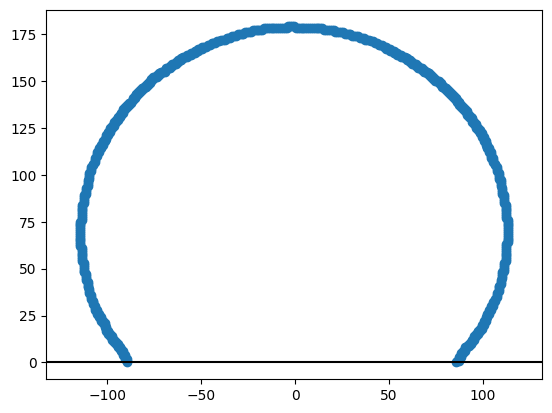

In [30]:
# Center the xs coordinates by subtracting their mean
xs = xs - xs.mean()
# Shift ys so that the minimum value is at zero (bottom of the drop)
ys = ys - ys.min()

# Plot the edges after centering and shifting
plt.figure()
plt.plot(xs, ys, marker='o', ls='none')
plt.axhline(0, color='k')   # Draw horizontal line at y=0 for reference
plt.axis('equal')           # Ensure equal aspect ratio
plt.show()


#### Converting Pixel Coordinates to Physical Units

This code converts the centered and shifted edge coordinates from pixel units to millimeters using the known image resolution. This step is essential for quantitative analysis and comparison with physical measurements.

In [31]:
# Convert pixel coordinates to millimeters using the image resolution
# 'res' is the number of pixels per millimeter
res = 120
xs /= res  # x-coordinates in mm
ys /= res  # y-coordinates in mm

#### Plotting Centered and Shifted Edge Coordinates
This code visualizes the centered and shifted droplet edge points in both full and zoomed-in views using subplots. The plots help verify the alignment of the drop base and the effectiveness of the coordinate transformation.

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


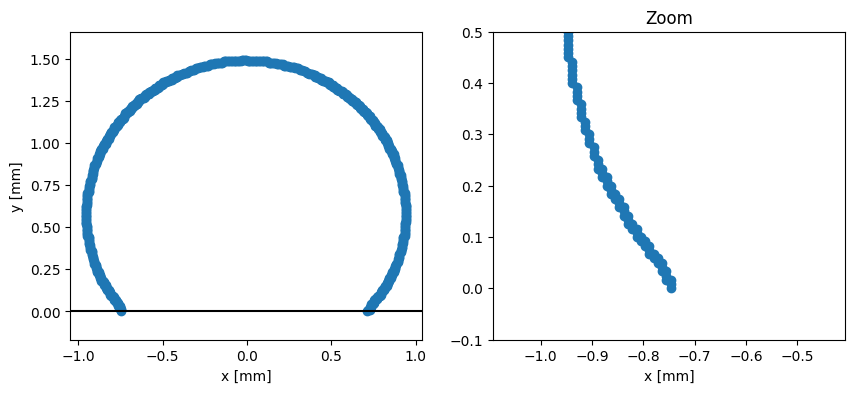

In [32]:
#Plot the edges
fig, axs = plt.subplots(1, 2, figsize=(10,4))
plt.sca(axs[0])
plt.plot(xs, ys, marker='o', ls='none')
plt.axhline(0, color='k')
plt.axis('equal')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')

#Plot a zoom on the edge
plt.sca(axs[1])
plt.plot(xs, ys, marker='o', ls='none')
plt.axis('equal')
plt.xlabel('x [mm]')
plt.xlim(-0.9, -0.6)
plt.ylim(-0.1, 0.5)
plt.title("Zoom")
plt.show()

#### Spline Fitting of Drop Edge in Polar Coordinates
This code converts the droplet edge points from Cartesian to polar coordinates, sorts them by angle, and fits a quintic spline to the radial profile. The fitted spline provides a smooth representation of the drop edge, which is then plotted alongside the original edge points for both the full profile and a zoomed-in region. This enables accurate geometric analysis and further physical parameter extraction.

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


theta range: 0.00 to 3.14 radians


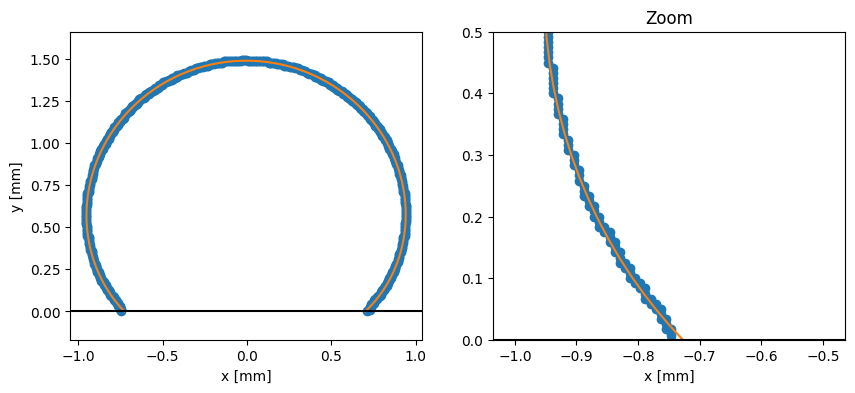

In [33]:
# Convert Cartesian coordinates (xs, ys) to polar coordinates (theta, r)
theta = np.arctan2(ys, xs)  # Angle from x-axis for each edge point
print(f"theta range: {theta.min():.2f} to {theta.max():.2f} radians")
r = np.sqrt(xs**2 + ys**2)  # Radial distance from origin for each edge point

# Sort edge points by angle to ensure smooth interpolation
# Sort the points based on theta to maintain the order around the droplet
sort_idx = np.argsort(theta)
theta_sorted = theta[sort_idx]
r_sorted = r[sort_idx]

# Fit a spline to the droplet edge in polar coordinates
import scipy.interpolate as spint
edge_f = spint.UnivariateSpline(theta_sorted, r_sorted, k=5, s=0.1)  # k=5: quintic spline, s=0.1: smoothing

# Evaluate the fitted edge function to get smoothed (x, y) coordinates
# Take 100 points in theta for a smooth curve and convert back to Cartesian coordinates
theta_fit = np.linspace(theta_sorted.min(), theta_sorted.max(), 100)  # 100 points for smoothness
xs_fit = edge_f(theta_fit) * np.cos(theta_fit)
ys_fit = edge_f(theta_fit) * np.sin(theta_fit)

# Display the original and fitted edge profiles
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot full edge profile
plt.sca(axs[0])
plt.plot(xs, ys, marker='o', ls='none', label='Edge points')
plt.plot(xs_fit, ys_fit, label='Spline fit')
plt.axhline(0, color='k')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.axis('equal')

# Plot zoomed-in view of the edge
plt.sca(axs[1])
plt.plot(xs, ys, marker='o', ls='none', label='Edge points')
plt.plot(xs_fit, ys_fit, label='Spline fit')
plt.axhline(0, color='k')
plt.axis('equal')
plt.xlabel('x [mm]')
plt.xlim(-0.8, -0.7)
plt.ylim(0, 0.5)
plt.title("Zoom")
plt.show()

#### Calculating Contact Angles at Drop Edges
This code evaluates the contact angles at the left and right edges of the droplet by computing the tangent slopes from the fitted polar spline. The angles are calculated in degrees and printed, providing quantitative insight into the wetting behavior at both contact points.

In [34]:
# Evaluate the contact angle at the left and right edges using the polar spline

# Get theta values corresponding to the left and right edges
theta_right = theta_sorted[0]
theta_left = theta_sorted[-1]

# Get the derivative dr/dtheta at the left and right edges
dr_dtheta = edge_f.derivative()

# Compute tangent vector in Cartesian coordinates at each edge
def tangent_angle(theta_val):
    r_val = edge_f(theta_val)
    dr_val = dr_dtheta(theta_val)
    # Tangent vector components magnitude using the chain rule for derivatives
    dx = dr_val * np.cos(theta_val) - r_val * np.sin(theta_val)
    dy = dr_val * np.sin(theta_val) + r_val * np.cos(theta_val)
    # Contact angle with respect to horizontal (x-axis)
    return np.arctan2(dy, dx)

angle_left = tangent_angle(theta_left)
angle_right = tangent_angle(theta_right)

print(f"Left contact angle: {np.degrees(angle_left) + 180:.2f} deg")
print(f"Right contact angle: {np.degrees(angle_right):.2f} deg")


Left contact angle: 133.88 deg
Right contact angle: 43.42 deg


#### Visualizing Fitted Edge and Contact Angles
This code plots the detected droplet edge points and the fitted spline profile, then overlays lines representing the left and right contact angles at the drop base. The visualization helps confirm the accuracy of the spline fit and the calculated contact angles.

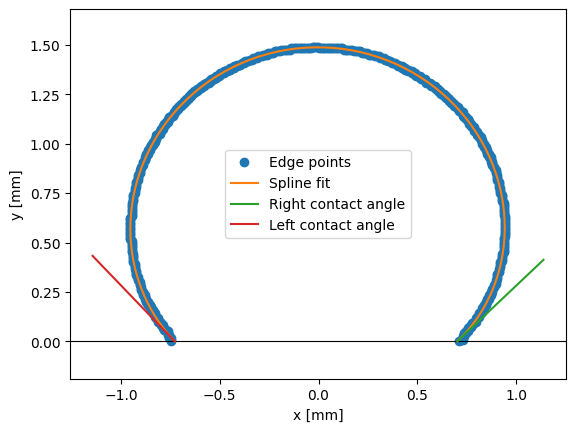

In [35]:
# Display the fitted edge and contact angles
plt.figure()
plt.plot(xs, ys, marker='o', ls='none', label='Edge points')
plt.plot(xs_fit, ys_fit, label='Spline fit')
plt.axhline(0, color='k', linewidth=0.8)

# Draw contact angle lines at left and right contact points using the tangent angles
angle_len = 0.6
plt.plot(
    [xs_fit[0], xs_fit[0] + angle_len * np.cos(angle_right)],
    [ys_fit[0], ys_fit[0] + angle_len * np.sin(angle_right)],
    label='Right contact angle'
)
plt.plot(
    [xs_fit[-1], xs_fit[-1] - angle_len * np.cos(angle_left)],
    [ys_fit[-1], ys_fit[-1] - angle_len * np.sin(angle_left)],
    label='Left contact angle'
)

plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.axis('equal')
plt.legend()
plt.show()

#### Calculating Radius of Curvature at Drop Apex
This code computes the radius of curvature at the apex of the droplet using the fitted polar spline. It evaluates the first and second derivatives of the spline at the apex angle and applies the polar curvature formula. The result is compared to the drop's base radius and height for validation.

In [36]:
# Calculate derivatives of the polar spline at theta = np.pi/2 (apex)
theta_apex = np.pi / 2
r_apex = edge_f(theta_apex)
dr_apex = edge_f.derivative(1)(theta_apex)
d2r_apex = edge_f.derivative(2)(theta_apex)

# Radius of curvature formula in polar coordinates
# Formula for radius of curvature at apex in polar coordinates:
#   R = ((r^2 + (dr/dθ)^2)^(3/2)) / |r^2 + 2(dr/dθ)^2 - r(d²r/dθ²)|
R_apex_polar = ((r_apex**2 + dr_apex**2)**1.5) / abs(r_apex**2 + 2*dr_apex**2 - r_apex*d2r_apex)

# Compare to drop height and base radius for reasonableness
base_radius_est = (xs.max() - xs.min()) / 2
print(f"Estimated base radius (half width): {base_radius_est:.4f} mm")
print(f"Drop height (max ys): {ys.max():.4f} mm")
print(f"Radius of curvature at apex (polar): {R_apex_polar:.4f} mm")


Estimated base radius (half width): 0.9500 mm
Drop height (max ys): 1.4917 mm
Radius of curvature at apex (polar): 0.9700 mm


#### Arc Length Parameterization of the Drop Edge

This code computes the arc length parameterization of the droplet edge using the fitted polar spline. It generates interpolated (x, y) coordinates along the arc length for both the left and right sides of the drop, enabling direct comparison with theoretical profiles and facilitating Young-Laplace equation fitting. The parameterized edge is then visualized alongside the spline fit.

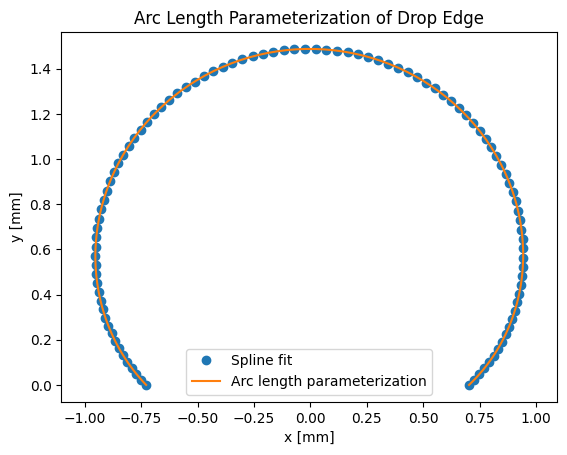

In [37]:
# Arc length parameterization of the drop edge to be used for fitting using the Young-Laplace equation
from scipy.interpolate import UnivariateSpline, interp1d

# Function to compute arc length parameterization of the drop edge
def get_half_arc_length_parametric(edge_f, theta_start, theta_end, num_points=1000) :
    # Define theta range from apex (theta=pi/2) to right edge (theta=0)
    theta_arc = np.linspace(theta_start, theta_end, num_points)
    r_arc = edge_f(theta_arc)
    x_arc = r_arc * np.cos(theta_arc)
    y_arc = r_arc * np.sin(theta_arc)
    # Compute incremental arc lengths
    # add up the differences in x and y coordinates to get the arc length to get the arc length
    ds = np.sqrt(np.diff(x_arc)**2 + np.diff(y_arc)**2)
    s_arc = np.concatenate([[0], np.cumsum(ds)])

    # Interpolation functions for x(s) and y(s)
    # get points along the arc length parameterization by interpolating x and y coordinates for later fitting
    x_s = interp1d(s_arc, x_arc, kind='cubic')
    y_s = interp1d(s_arc, y_arc, kind='cubic')
    s_arc_half = np.linspace(0, s_arc.max(), 100)
    x_arc_half = x_s(s_arc_half)
    y_arc_half = y_s(s_arc_half)
    return s_arc_half,x_arc_half, y_arc_half

s_arc_right, x_arc_right, y_arc_right = get_half_arc_length_parametric(edge_f, np.pi/2, 0)
s_arc_left, x_arc_left, y_arc_left = get_half_arc_length_parametric(edge_f, np.pi/2, np.pi)

# Plot the arc length parameterization
plt.figure()
plt.plot(xs_fit, ys_fit, 'o', label='Spline fit')
plt.plot(np.r_[x_arc_left[::-1], x_arc_right], np.r_[y_arc_left[::-1], y_arc_right], label='Arc length parameterization')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.axis('equal')
plt.legend()
plt.title('Arc Length Parameterization of Drop Edge')
plt.show()


##### Young-Laplace Shape ODE System

This code defines the system of ordinary differential equations (ODEs) describing the theoretical drop profile according to the Young-Laplace equation. The function `shape_equations` models the evolution of the drop's tangent angle and coordinates along the arc length, incorporating the effects of gravity and surface tension. This ODE system is used to generate theoretical drop shapes for comparison and fitting to experimental data.

In [38]:
# Young-Laplace shape ODE system
def shape_equations(s, Y, beta):
    # Y = [theta, x, y]: theta is the angle, x and y are coordinates
    theta, x, y = Y
    if x == 0:
        curvature_term = 1  # curvature term for zero x, derived from the limit of sin(theta)/x as x approaches 0
    else:
        curvature_term = np.sin(theta) / x  # curvature term for nonzero x

    # ODEs for drop profile:
    # dtheta/ds: change of angle along arc length
    # dx/ds: change of x along arc length
    # dy/ds: change of y along arc length
    # Reference: O. I. del Rı́o and A. W. Neumann, Journal of Colloid and Interface Science 196, 136 (1997).

    # 3 derivatives of Young-Laplace equation
    dtheta_ds = 2 + beta * y - curvature_term
    dx_ds = np.cos(theta)
    dy_ds = np.sin(theta)
    return [dtheta_ds, dx_ds, dy_ds]


##### Generating Theoretical Young-Laplace Drop Profile

This code defines a function to numerically generate the theoretical drop shape profile by integrating the Young-Laplace ODE system from the apex. It uses initial guesses for the apex radius and surface tension, along with the density difference, to compute the dimensionless Bond number and solve the ODEs. The resulting arc length, x, and y coordinates describe the predicted drop shape for comparison and fitting to experimental data.

In [39]:
from scipy.integrate import solve_ivp
# Physical constants
g = 9.81  # gravitational acceleration, m/s^2

# Generate theoretical Young-Laplace drop shape from apex
def generate_profile(b, gamma, delta_rho):
    # Calculate dimensionless Bond number (beta)
    # b = base radius of the drop in mm
    # gamma = surface tension of the liquid in N/m
    beta = delta_rho * g * b**2 / gamma

    # Initial conditions at apex (top of drop)
    theta0 = 0    # angle at apex
    x0 = 0        # x-coordinate at apex
    y0 = 0        # y-coordinate at apex
    Y0 = [theta0, x0, y0]

    # Approximate total arclength to integrate (can be tuned)
    # in units of b
    s_max = np.pi-0.1

    # Integrate the Young-Laplace ODE system
    sol = solve_ivp(
        shape_equations,           # ODE system
        [0, s_max],                # integration interval
        Y0,                        # initial conditions
        args=(beta,),              # additional arguments for ODE
        dense_output=True,         # allow interpolation
        max_step=0.05              # maximum step size
    )

    # Extract x and y coordinates of the profile through integration
    # list of arc lengths, x and y coordinates
    s_model = sol.t*b*1000  # convert to mm
    x_model = sol.y[1]*b*1000  # convert to mm
    y_model = sol.y[2]*b*1000  # convert to mm

    return s_model, x_model, y_model

##### Initial Young-Laplace Profile Visualization

This code generates an initial theoretical drop profile using the Young-Laplace equation with estimated parameters and overlays it with the experimental spline-fitted drop edge. The plot provides a visual comparison between the experimental data and the theoretical model, serving as a baseline for subsequent parameter fitting.

(65,) 2.9807608005179973


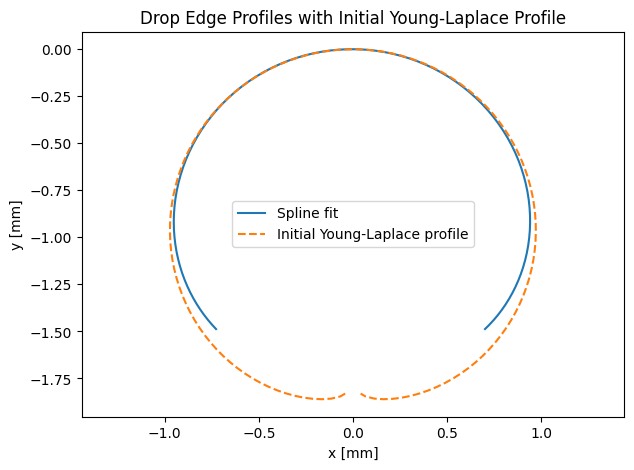

In [40]:
# check some initial parameters to get some feedback on the model
b0 = 0.98e-3   # approximate apex radius in meters (initial guess)
gamma0 = 0.2  # approximate surface tension in N/m (initial guess, water ~0.072)
# Here assuming water/air, but obviously this is not necessarily the case
# Generate theoretical Young-Laplace profile for initial guess parameters
# example values for water/air system, to be modified as needed
rho_liquid = 1000  # density of liquid (e.g., water), kg/m^3
rho_air = 1.2      # density of air, kg/m^3
delta_rho = rho_liquid - rho_air  # density difference, kg/m^3
s_model_fit, x_model_init, y_model_init = generate_profile(b0, gamma0, delta_rho)
print(s_model_fit.shape, s_model_fit[-1])

# Plot the initial theoretical profile together with the experimental edge
plt.figure(figsize=(7, 5))
plt.plot(xs_fit, (ys_fit-ys_fit.max()), '-', label='Spline fit')
plt.plot(np.r_[-x_model_init[::-1], x_model_init], -np.r_[y_model_init[::-1], y_model_init], '--', label='Initial Young-Laplace profile')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.title('Drop Edge Profiles with Initial Young-Laplace Profile')
plt.legend()
plt.axis('equal')
plt.show()

#### Fitting Experimental and Theoretical Drop Profiles
This code defines the cost function which quantifies the difference between the experimental drop edge and the theoretical Young-Laplace profile by interpolating both onto a common arc length and computing the root mean square error. By minimizing this cost, the model parameters (apex radius, surface tension, and optionally density difference) are optimized to achieve the best overlay between experiment and theory.

In [41]:
# ----------------------------
# Cost function to minimize for Young-Laplace profile fitting
# ----------------------------
def cost(params, data_ref):
    b, gamma, delta_rho = params
    # Generate theoretical profile for given parameters
    s_model, x_model, y_model = generate_profile(b, gamma, delta_rho)

    # create interpolation model for the model profile
    x_s_model = interp1d(s_model, x_model, kind='cubic', fill_value='extrapolate')
    y_s_model = interp1d(s_model, y_model, kind='cubic', fill_value='extrapolate')

    x_model_interp = x_s_model(data_ref[0])
    y_model_interp = y_s_model(data_ref[0])
    # Calculate root mean square error between experimental and model profile
    diff = np.r_[data_ref[1] - x_model_interp, data_ref[2] - y_model_interp]
    return np.sqrt(np.mean(diff**2))

# Function to compute cost given a fixed delta_rho where delta_rho is the density difference
def cost_given_delta_rho(params, data_ref):
    b, gamma = params
    return cost([b, gamma, delta_rho], data_ref)

#### Fitting Experimental and Theoretical Drop Profiles
This code defines the cost function which quantifies the difference between the experimental drop edge and the theoretical Young-Laplace profile by interpolating both onto a common arc length and computing the root mean square error. By minimizing this cost, the model parameters (apex radius, surface tension, and optionally density difference) are optimized to achieve the best overlay between experiment and theory.

In [42]:
#Given defined constant delta_rho (density difference)

# ----------------------------
# Initial guesses for fitting Young-Laplace profile
# ----------------------------
# example values for water/air system, to be modified as needed
rho_liquid = 1000  # density of liquid (e.g., water), kg/m^3
rho_air = 1.2      
# density of air, kg/m^3
delta_rho = rho_liquid - rho_air  # density difference, kg/m^3

b0 = 0.6e-3   # approximate apex radius in meters (initial guess)
gamma0 = 0.06  # approximate surface tension in N/m (initial guess, water ~0.072)

dat_ref = (np.r_[s_arc_left, s_arc_right], np.r_[-x_arc_left, x_arc_right], -np.r_[y_arc_left-y_arc_left.max(), y_arc_right-y_arc_right.max()])

from scipy.optimize import minimize
# Minimize the cost function to fit the theoretical profile to experimental data
# use cost function defined above to fit the Young-Laplace profile
# Bounds: b in [0.1 mm, 5 mm], gamma in [0.02, 0.1] N/m
res = minimize(cost_given_delta_rho, [b0, gamma0], args=(dat_ref,), bounds=[(1e-4, 5e-3), (0.02, 0.1)], method='L-BFGS-B')

# Extract fitted parameters: apex radius and surface tension
b_fit, gamma_fit = res.x

print(f"Fitted apex radius b: {b_fit*1e3:.6f} mm")
print(f"Fitted surface tension γ: {gamma_fit:.6f} N/m")
print(f"Fitting residual: {res.fun:.6f}")

# ----------------------------
# Generate and plot the fitted Young-Laplace profile
# ----------------------------
s_model_fit, x_model_fit, y_model_fit = generate_profile(b_fit, gamma_fit, delta_rho)
# truncate the model_fit to match the experimental data
x_model_fit = x_model_fit[s_model_fit <= s_arc_right.max()+0.05]
y_model_fit = y_model_fit[s_model_fit <= s_arc_right.max()+0.05]

Fitted apex radius b: 0.971727 mm
Fitted surface tension γ: 0.055292 N/m
Fitting residual: 0.004338


#### Visualizing Fitted Young-Laplace Profile

This code plots the experimental droplet edge (spline fit) alongside the Young-Laplace profile fitted with a fixed density difference. The overlay allows visual assessment of the agreement between experimental data and the theoretical model.

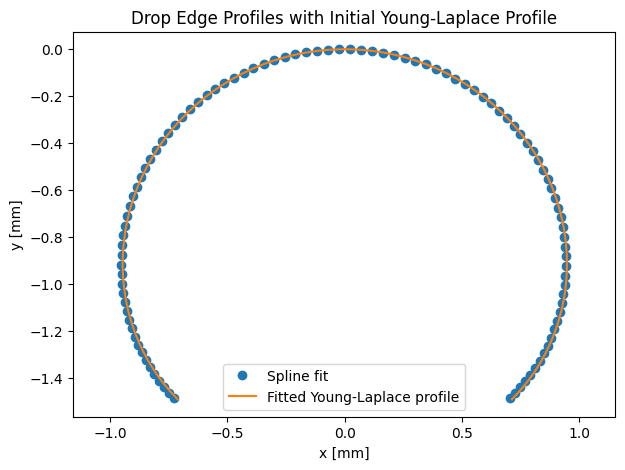

In [43]:
# Plot the initial theoretical profile together with the experimental edge
plt.figure(figsize=(7, 5))
plt.plot(xs_fit, (ys_fit-ys_fit.max()), 'o', label='Spline fit')
plt.plot(np.r_[-x_model_fit[::-1], x_model_fit], -np.r_[y_model_fit[::-1], y_model_fit], '-', label='Fitted Young-Laplace profile')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.title('Drop Edge Profiles with Initial Young-Laplace Profile')
plt.legend()
plt.axis('equal')
plt.show()

#### Young-Laplace Profile Fitting with Density Difference as a Free Parameter

This code fits the theoretical Young-Laplace drop profile to the experimental edge data by optimizing the apex radius, surface tension, and density difference simultaneously. The fitting minimizes the root mean square error between the experimental and model profiles, and outputs the best-fit parameters and residual.

In [44]:
# Treat density difference as a fitting parameter as well

# ----------------------------
# Treat density difference as a parameter
# ----------------------------
b0 = 0.6e-3   # approximate apex radius in meters (initial guess)
gamma0 = 0.06  # approximate surface tension in N/m (initial guess, water ~0.072)

dat_ref = (np.r_[s_arc_left, s_arc_right], np.r_[-x_arc_left, x_arc_right], -np.r_[y_arc_left-y_arc_left.max(), y_arc_right-y_arc_right.max()])

from scipy.optimize import minimize
# Minimize the cost function to fit the theoretical profile to experimental data
# use cost function defined above to fit the Young-Laplace profile
# Bounds: b in [0.1 mm, 5 mm], gamma in [0.02, 0.1] N/m
res = minimize(cost, [b0, gamma0, delta_rho], args=(dat_ref,), bounds=[(1e-4, 5e-3), (0.02, 0.1), (10, 5000)], method='L-BFGS-B')

# Extract fitted parameters: apex radius and surface tension
b_fit, gamma_fit, delta_rho_fit = res.x

print(f"Fitted apex radius b: {b_fit*1e3:.6f} mm")
print(f"Fitted surface tension γ: {gamma_fit:.6f} N/m")
print(f"Fitted density difference Δρ: {delta_rho_fit:.6f} kg/m³")
print(f"Fitting residual: {res.fun:.6f}")

# ----------------------------
# Generate and plot the fitted Young-Laplace profile
# ----------------------------
s_model_fit, x_model_fit, y_model_fit = generate_profile(b_fit, gamma_fit, delta_rho)
# truncate the model_fit to match the experimental data
x_model_fit = x_model_fit[s_model_fit <= s_arc_right.max()+0.05]
y_model_fit = y_model_fit[s_model_fit <= s_arc_right.max()+0.05]

Fitted apex radius b: 0.971727 mm
Fitted surface tension γ: 0.055292 N/m
Fitted density difference Δρ: 998.800040 kg/m³
Fitting residual: 0.004338


#### Visualizing Fitted Young-Laplace Profile

This code plots the experimental droplet edge (spline fit) together with the Young-Laplace profile fitted using apex radius, surface tension, and density difference as free parameters. The overlay allows visual comparison of the experimental data and the optimized theoretical model.

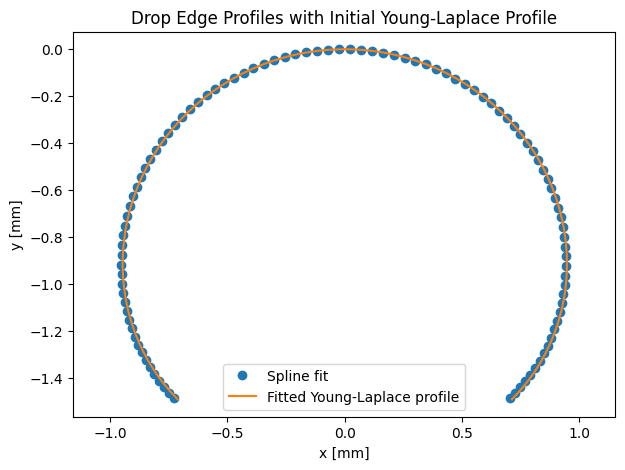

In [45]:
plt.figure(figsize=(7, 5))
plt.plot(xs_fit, (ys_fit-ys_fit.max()), 'o', label='Spline fit')
plt.plot(np.r_[-x_model_fit[::-1], x_model_fit], -np.r_[y_model_fit[::-1], y_model_fit], '-', label='Fitted Young-Laplace profile')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.title('Drop Edge Profiles with Initial Young-Laplace Profile')
plt.legend()
plt.axis('equal')
plt.show()

#### Calculating Pressure Difference Across the Drop

This code computes the pressure difference (ΔP) across the droplet interface using the Young-Laplace equation, based on the fitted surface tension and apex radius. The result is printed in Pascals, providing insight into the capillary pressure sustained by the drop.

In [22]:
# Calculate pressure difference using Young-Laplace equation
delta_P = 2*gamma_fit / b_fit  # (N/m) / (m) = Pa

print(f"Pressure difference ΔP: {delta_P:.2f} Pa")

Pressure difference ΔP: 113.80 Pa
